In [1]:
%pylab inline
%matplotlib inline
import io
import h5py 
import pandas as pd
import scipy as sp
import numpy as np
from PIL import Image
from fractions import Fraction

from scipy import optimize 
from scipy.optimize import curve_fit,least_squares
from lmfit.models import GaussianModel
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colorbar import ColorbarBase, make_axes_gridspec


Populating the interactive namespace from numpy and matplotlib


In [2]:
## Using the original lengths and widths give to me, the volume was a little smaller than 200
## 1.3 inch width had holes on a trapezoid corner and it created too many edges, the code would not work
##  I used all the length decimal places in geant4
volume = 199.7
mass = volume/(2.54**3) # convert to cubic inch
width = np.arange(1,1.8,0.1)
width[3]=1.25 # remove error data set
length = double( mass/width**2)
print('Units = inch')
print('Lengths:\t\twidths:')
for i in range(len(length)):
    print('{:>17.15f}'.format(length[i]),'\t','{:.2f}'.format(width[i]))

Units = inch
Lengths:		widths:
12.186441695718035 	 1.00
10.071439417948786 	 1.10
8.462806733137521 	 1.20
7.799322685259543 	 1.25
6.217572293733688 	 1.40
5.416196309208012 	 1.50
4.760328787389854 	 1.60
4.216761832428383 	 1.70


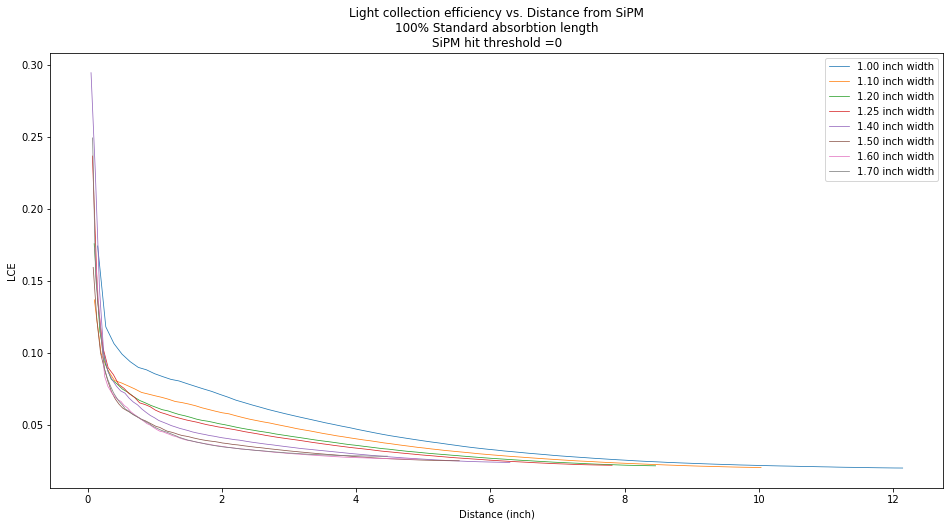

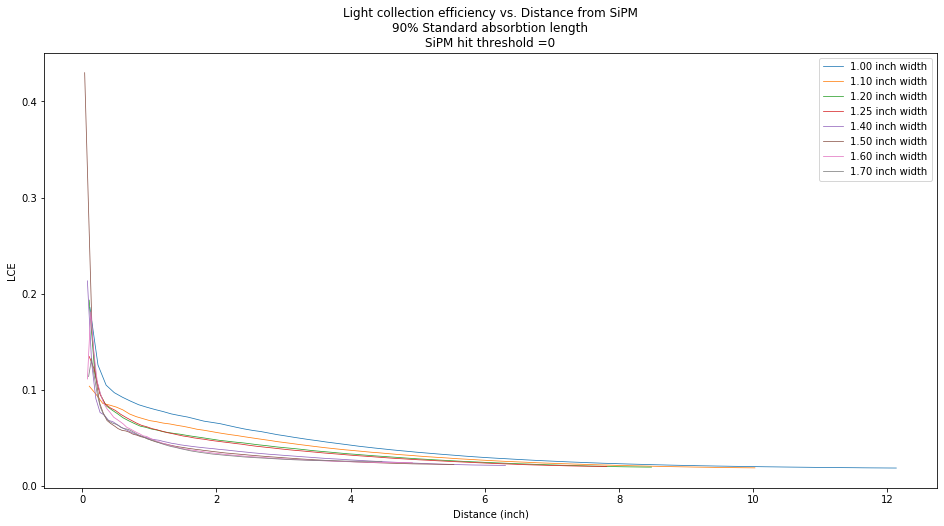

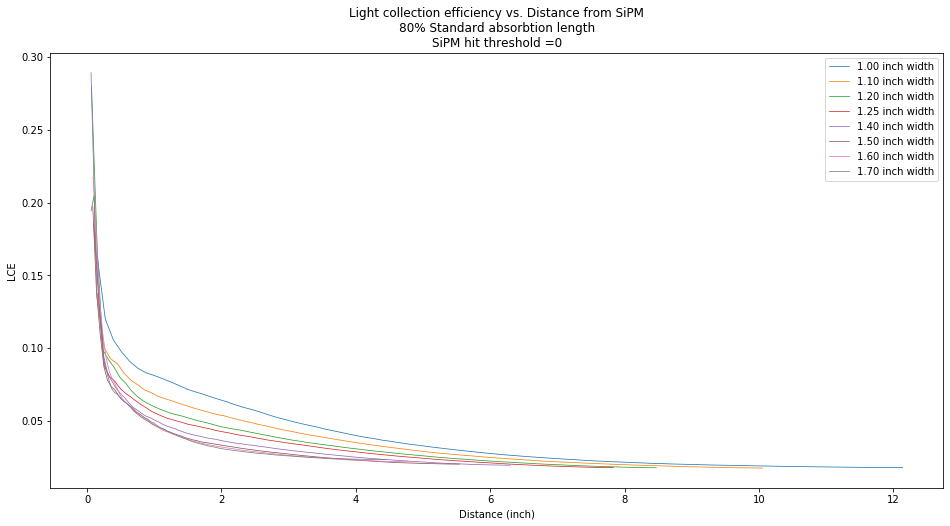

In [52]:
## Single SiPM data with various thicknesses from 1.0 inch to 1.7 inch
## The absorbtion lengths were reduced by 10 and 20 percent on the second and third graphs

# Thresholds minimums
energy_deposit_threshold = 0.0
photon_threshold = 0
SiPM_hit_threshold = 0
LCE_threshold = 0
distance_threshold =  0 #inch

# indexing for data sets
widths = 8
absorb= np.array([100,90,80]) # percent of absorbtion lengths
ABL_n = len(absorb) 


# Arrays
bins = 100                                # distance from SiPM
mins = np.zeros((ABL_n,widths))          # minimum distance
maxs = np.zeros((ABL_n,widths))          # maximum didtance
bes = np.zeros((ABL_n,widths,bins+1))    # bin edges
bcs = np.zeros((ABL_n,widths,bins))      # bin centers
averages = np.zeros((ABL_n,widths,bins)) # average LCE per distances


# Import csv files and create data frame
#  i = absorbtion length percent {100, 90, 80}
#  j = width of detector {1.0, 1.1, 1.2, 1.25, 1.4, 1.5, 1.6, 1.7}
dfs = []
for i in range(ABL_n):
    fileName = [[] for i in range(widths)]
    df = []
    nmp = []
    pos = []
    dist = []
    for j in range(widths):
        prefix1 = 'constant_volume_200/build-constant_volume/LXe_200_gram_'
        i=i
        root = '_nt_'
        j=j
        csv ='.csv'
        fileName[j].append(f'{prefix1}{i}{root}{j}{csv}')
        df.append(pd.read_csv(fileName[j][0], sep=',',header=None, skiprows=range(0,10),
                    names=('Energy Deposited', 'SiPM Hits', 'Photons',
                            'x_pos','y_pos','z_pos')))
        df[j]['LCE']=df[j]['SiPM Hits']/df[j]['Photons']
        df[j]['log(LCE)']=log(df[j]['SiPM Hits']/df[j]['Photons'])
        nmp.append(df[j].to_numpy())
        pos.append(nmp[j][:,3:6])
        pos[j][:,2]=pos[j][:,2]-min(pos[j][:,2])
        pos[j]= pos[j]/25.4
        dist.append(sqrt(sum(pos[j]**2,axis=1)))
        df[j]['z_pos'] = pos[j][:,2].tolist()
        df[j]['y_pos'] = pos[j][:,1].tolist()
        df[j]['x_pos'] = pos[j][:,0].tolist()
        df[j]['Distance'] = dist[j].tolist()
    dfs.append(df)

# Graphs
titles = ['Light collection efficiency vs. Distance from SiPM',
          '% Standard absorbtion length',
          'SiPM hit threshold =']
for i in range(ABL_n):
    plt.figure(figsize=(16,8))
    plt.title('{}\n{}{}\n{}{}'.format(titles[0],absorb[i],titles[1],titles[2],SiPM_hit_threshold))
    plt.ylabel('LCE')
    plt.xlabel('Distance (inch)')
    for j in range(widths): 
        dfs[i][j] = dfs[i][j][dfs[i][j]['Energy Deposited']>=energy_deposit_threshold]
        dfs[i][j] = dfs[i][j][dfs[i][j]['Photons']>=photon_threshold]
        dfs[i][j] = dfs[i][j][dfs[i][j]['LCE']>=LCE_threshold]
        dfs[i][j] = dfs[i][j][dfs[i][j]['SiPM Hits']>=SiPM_hit_threshold]
        dfs[i][j] = dfs[i][j][dfs[i][j]['Distance']>=distance_threshold] 
        mins[i,j]= np.min(dfs[i][j]['Distance'])
        maxs[i,j]= np.max(dfs[i][j]['Distance'])
        bes[i,j,:] = np.linspace(mins[i,j],maxs[i,j],bins+1)
        bcs[i,j,:] = bes[i,j,:-1] + np.diff(bes[i,j,:]) / 2.
        arraY = dfs[i][j]['Distance']
        for k in range(bins):
            msk = arraY>=bes[i,j,k]
            mask = arraY<bes[i,j,k+1]
            mk = msk = mask         
            averages[i,j,k] = dfs[i][j]['LCE'][mk].mean()
            
        plt.plot(bcs[i,j],averages[i,j],label='{:.2f} inch width'.format(width[j]),lw=0.75)
    plt.legend()
    plt.show()
    

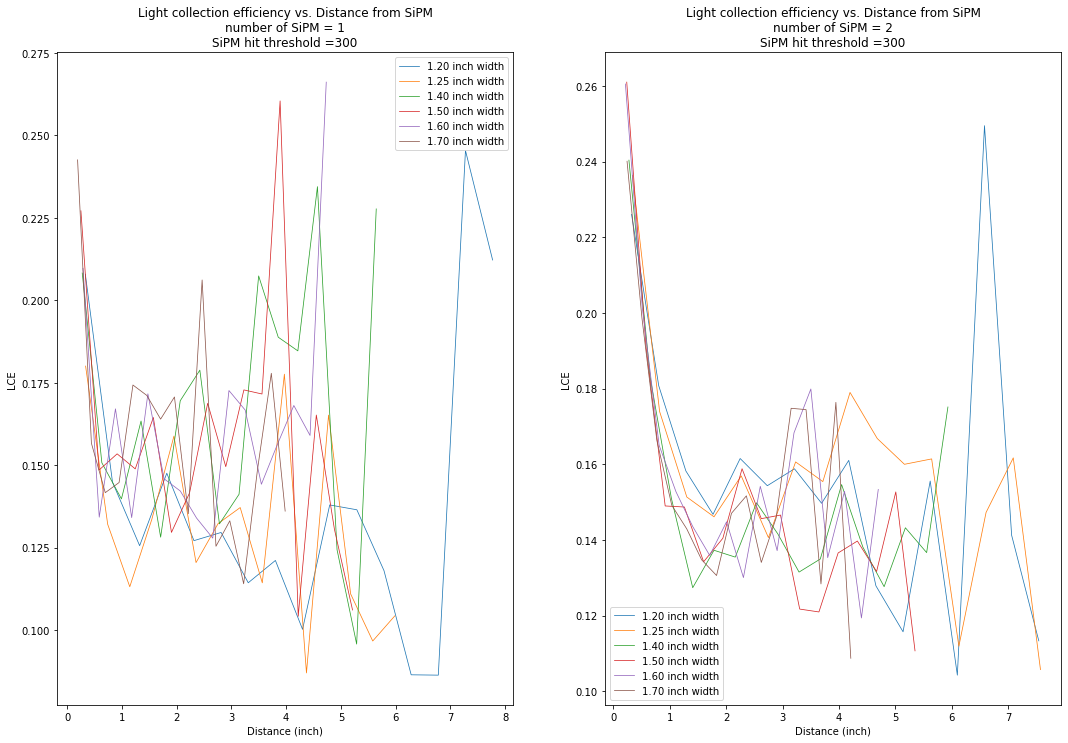

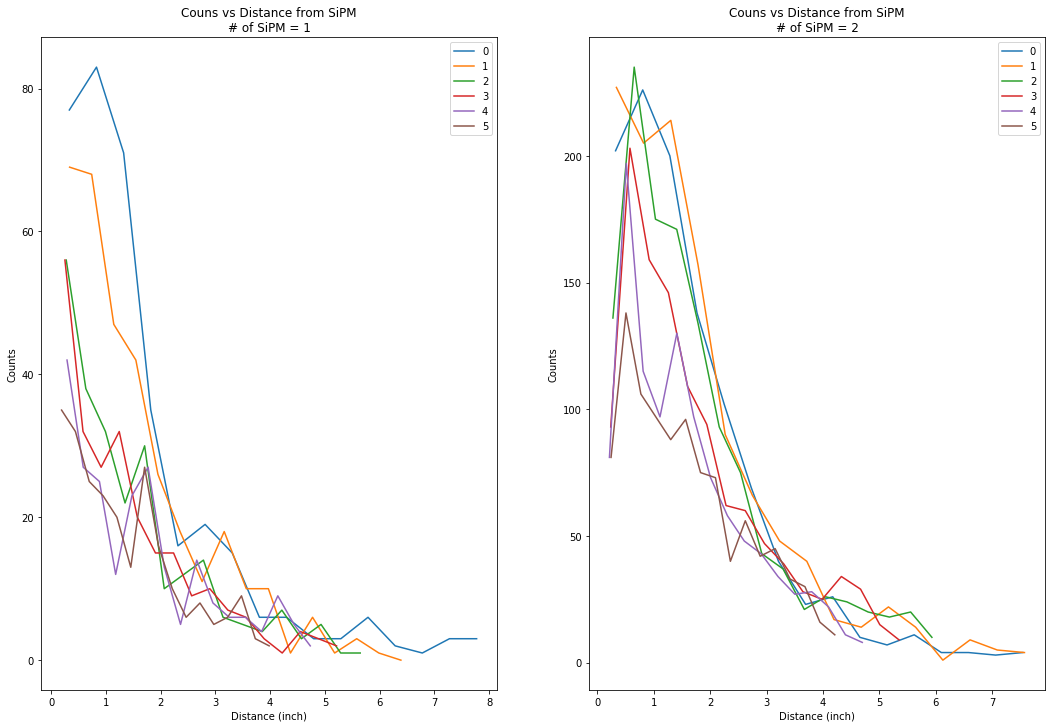

In [241]:

## Comparing one vs two SiPMs
## the widths were 1.2 inch to 1.7 inch

# Thresholds minimums
energy_deposit_threshold = 0.0
photon_threshold = 0
SiPM_hit_threshold = 300

LCE_threshold = 0.0
distance_threshold =  0 #inch

# Indexing for data sets
widths = 6
SiPM_n = 2 
dfs = []
bins = 16 # for distances from SiPM

energy_bins = 64
# Arrays

be = np.linspace(0, np.sqrt(0.7), energy_bins+1) ** 2
bc = be[:-1] + np.diff(be) / 2.

mins = np.zeros((SiPM_n,widths))          # minimum distance
maxs = np.zeros((SiPM_n,widths))          # maximum didtance
bes = np.zeros((SiPM_n,widths,bins+1))    # bin edges
bcs = np.zeros((SiPM_n,widths,bins))      # bin centers
averages = np.zeros((SiPM_n,widths,bins)) # average LCE per distances
spectrum = np.zeros((SiPM_n,widths,bins,energy_bins))
counts = np.zeros((SiPM_n,widths,bins))
# Import csv files and create data frame
#  i = number of SiPMs {1, 2}
#  j = width of detector {1.0, 1.1, 1.2, 1.25, 1.4, 1.5, 1.6, 1.7}
for i in range(SiPM_n):
    fileName = [[] for i in range(widths)]
    df = []
    nmp = []
    pos = []
    dist = []
    for j in range(widths):
        prefix1 = 'two_SiPM/build-twoSiPM/LXe_200_gram_'
        i=i
        root = '_SiPM_nt_'
        j=j
        csv ='.csv'
        fileName[j].append(f'{prefix1}{i+1}{root}{j+2}{csv}')
        df.append(pd.read_csv(fileName[j][0], sep=',',header=None, skiprows=range(0,10),
                    names=('Energy Deposited', 'SiPM Hits', 'Photons',
                            'x_pos','y_pos','z_pos')))
        df[j]['LCE']=df[j]['SiPM Hits']/df[j]['Photons']
        df[j]['log(LCE)']=log(df[j]['SiPM Hits']/df[j]['Photons'])
        nmp.append(df[j].to_numpy())
        pos.append(nmp[j][:,3:6])
        pos[j][:,2]=pos[j][:,2]-min(pos[j][:,2])
        pos[j]= pos[j]/25.4
        dist.append(sqrt(sum(pos[j]**2,axis=1)))
        df[j]['z_pos'] = pos[j][:,2].tolist()
        df[j]['y_pos'] = pos[j][:,1].tolist()
        df[j]['x_pos'] = pos[j][:,0].tolist()
        df[j]['Distance'] = dist[j].tolist()
    dfs.append(df)

## Graphs

# Graphs showing various lengths for one and two SiPMS
titles = ['Light collection efficiency vs. Distance from SiPM',
          'number of SiPM = ',
          'SiPM hit threshold =']
f = plt.figure(figsize=(18,12))
for i in range(SiPM_n):
    a = 121+i
    ax = f.add_subplot(a)
    plt.title('{}\n{}{}\n{}{}'.format(titles[0],titles[1],i+1,titles[2],SiPM_hit_threshold))
    plt.ylabel('LCE')
    plt.xlabel('Distance (inch)')
    for j in range(widths): 
        dfs[i][j] = dfs[i][j][dfs[i][j]['Energy Deposited']>=energy_deposit_threshold]
        dfs[i][j] = dfs[i][j][dfs[i][j]['Photons']>=photon_threshold]
        dfs[i][j] = dfs[i][j][dfs[i][j]['LCE']>=LCE_threshold]
        dfs[i][j] = dfs[i][j][dfs[i][j]['SiPM Hits']>=SiPM_hit_threshold]
        dfs[i][j] = dfs[i][j][dfs[i][j]['Distance']>=distance_threshold] 
        mins[i,j]= np.min(dfs[i][j]['Distance'])
        maxs[i,j]= np.max(dfs[i][j]['Distance'])
        bes[i,j,:] = np.linspace(mins[i,j],maxs[i,j],bins+1)
        bcs[i,j,:] = bes[i,j,:-1] + np.diff(bes[i,j,:]) / 2.
        arraY = dfs[i][j]['Distance'].to_numpy()
        for k in range(bins):
            
            msk = arraY>=bes[i,j,k]
            mask = arraY<bes[i,j,k+1]
            mk = msk == mask         
            averages[i,j,k] = dfs[i][j]['LCE'][mk].mean()
            counts[i,j,k]= len(argwhere(mk==True))
            spectrum[i,j,k], _ = np.histogram(dfs[i][j]['Energy Deposited'][mk], bins=be)
        plt.plot(bcs[i,j],averages[i,j],label='{:.2f} inch width'.format(width[j+2]),lw=0.75)
    plt.legend()
plt.show()

f = plt.figure(figsize=(18,12))

for i in range(2):
    a = 121+i
    ax = f.add_subplot(a)
    plt.title('Couns vs Distance from SiPM\n# of SiPM = {}'.format(1+i))
    plt.xlabel('Distance (inch)')
    plt.ylabel('Counts')
    for j in range(widths):
        plot(bcs[i,j],counts[i,j],label='{}'.format(j))
    legend()
show()


SyntaxError: invalid syntax (<ipython-input-211-2ce75884e564>, line 4)

In [180]:
# Graphs for each length comparing one and two SiPMs
# for i in range(widths):
#     plt.figure(figsize=(16,6))
#     plt.title('LCE vs distace from SiPM\n{:.2f} inch width'.format(width[i+2]))
#     plt.ylabel('LCE')
#     plt.xlabel('Distance (inch)')
#     plt.plot(bcs[0,i],averages[0,i],label='One SiPM',lw=0.75)
#     plt.plot(bcs[1,i],averages[1,i],label='Two SiPM',lw=0.75)
#     plt.legend()
#     plt.show()

Distance = 0.3 inch


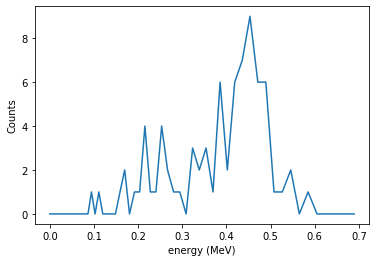

Distance = 0.8 inch


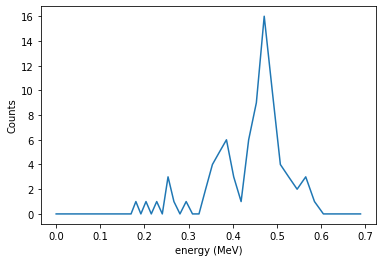

Distance = 1.3 inch


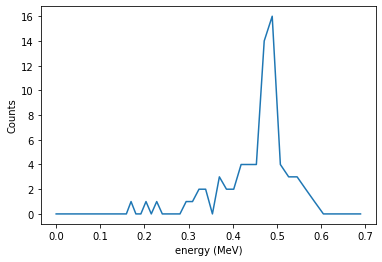

Distance = 1.8 inch


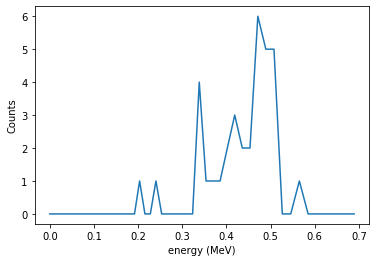

Distance = 2.3 inch


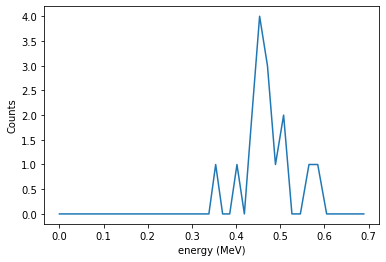

Distance = 2.8 inch


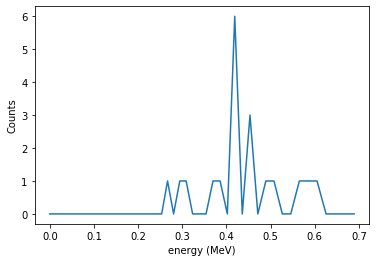

Distance = 3.3 inch


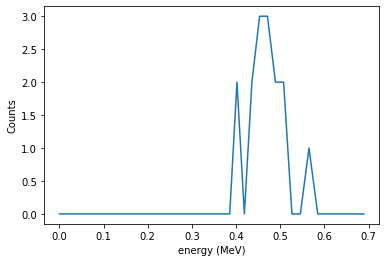

Distance = 3.8 inch


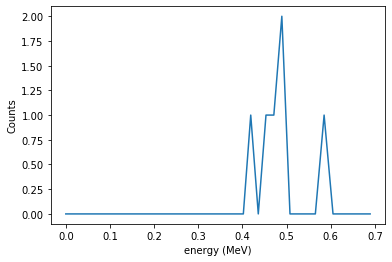

Distance = 4.3 inch


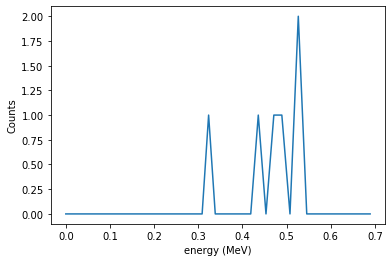

Distance = 4.8 inch


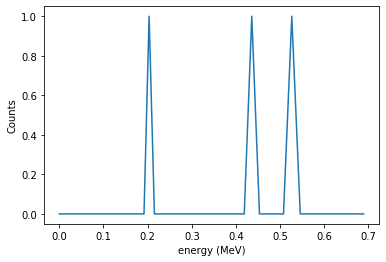

Distance = 5.3 inch


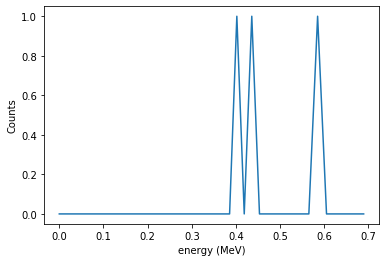

Distance = 5.8 inch


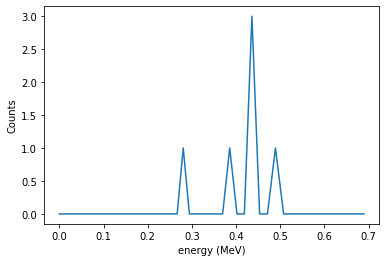

Distance = 6.3 inch


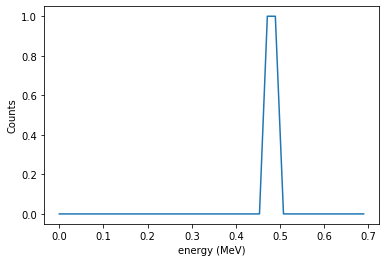

Distance = 6.8 inch


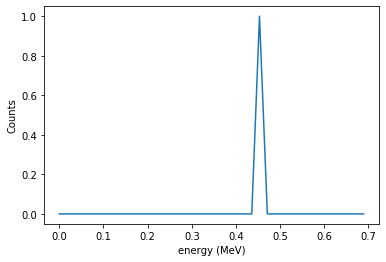

Distance = 7.3 inch


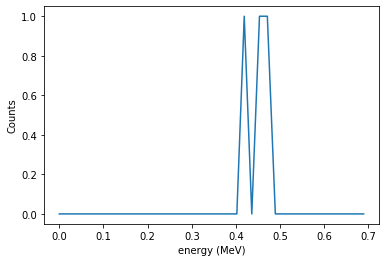

Distance = 7.8 inch


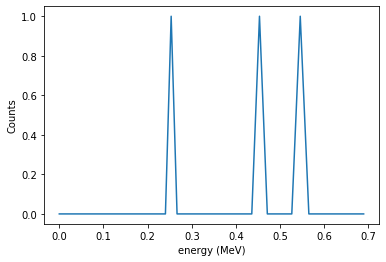

In [242]:
for i in range(bins):
    print('Distance = {:.1f} inch'.format(bcs[0,0,i]))
    plot(bc,spectrum[0,0,i])
    plt.xlabel('energy (MeV)')
    plt.ylabel('Counts')
    show()

In [51]:
# corner and center comparison at each SiPM side trapezoid
l = 0
import plotly.express as px
for i in range(6):

    fig = px.scatter_3d(dfs[l][i], x ='x_pos', y ='z_pos', z ='y_pos', color='log(LCE)')
    fig.update_scenes(aspectmode='data')
    fig.update_traces(opacity=1, selector=dict(type='scatter3d'))
    fig.update_traces(marker_size=1, selector=dict(type='scatter3d'))
    fig.update_traces(marker_colorscale='Hot', selector=dict(type='scatter3d'))
    fig.show()



In [44]:
dfs[0][0]

,Energy Deposited,SiPM Hits,Photons,x_pos,y_pos,z_pos,LCE,log(LCE),Distance
1551,0.445718,1273,3500,-0.130336,0.010361,0.217008,0.363714,-1.011387,0.253352
2301,0.493101,1118,3944,-0.142034,-0.270289,0.524480,0.283469,-1.260654,0.606885
2544,0.474944,1080,3803,-0.103573,-0.106848,0.094724,0.283986,-1.258829,0.176399
2706,0.457192,1138,3738,0.069563,-0.240311,0.021024,0.304441,-1.189278,0.251059
3994,0.587828,1358,4580,0.871142,0.055236,2.829067,0.296507,-1.215686,2.960669
4129,0.477746,1089,3696,-0.169989,0.053328,0.829949,0.294643,-1.221991,0.848855
4157,0.494550,1588,3793,-0.256194,-0.074020,0.096693,0.418666,-0.870682,0.283661
4288,0.322037,1041,2582,0.001768,0.083494,0.015000,0.403176,-0.908383,0.084849
4710,0.502812,1088,3971,0.279723,0.512343,1.481783,0.273986,-1.294677,1.592615
6422,0.480362,1288,3834,0.217848,-0.535673,2.220193,0.335942,-1.090818,2.294267


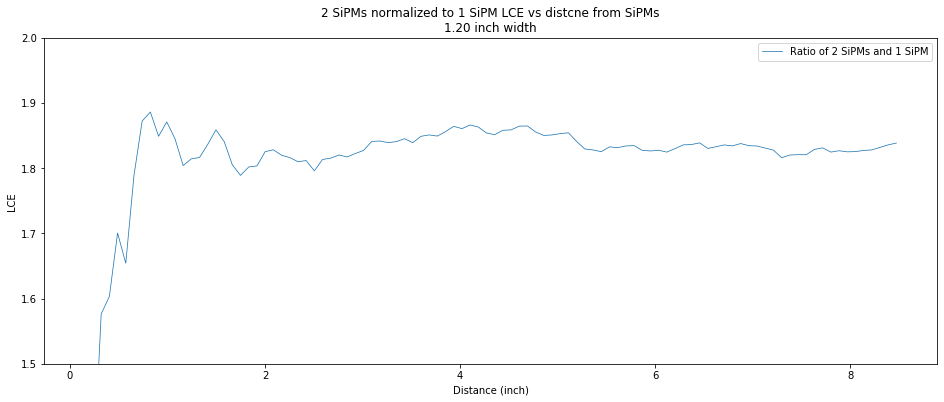

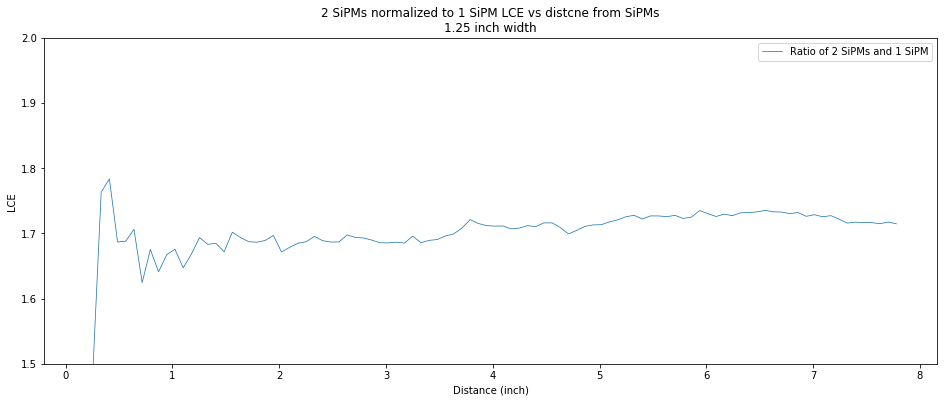

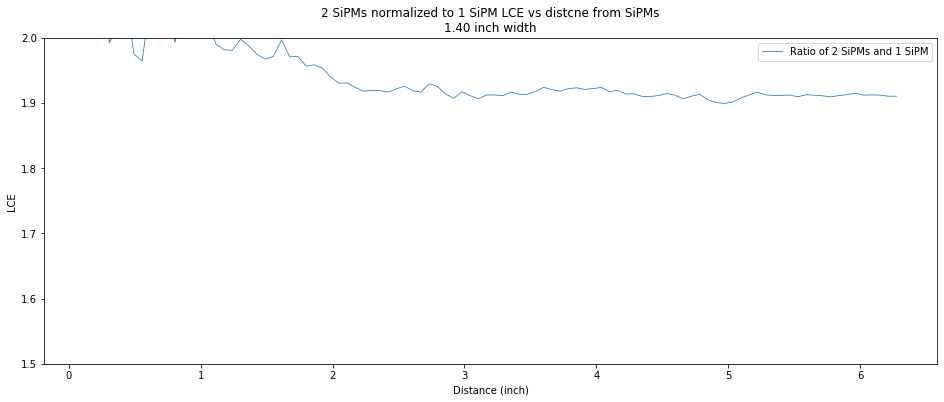

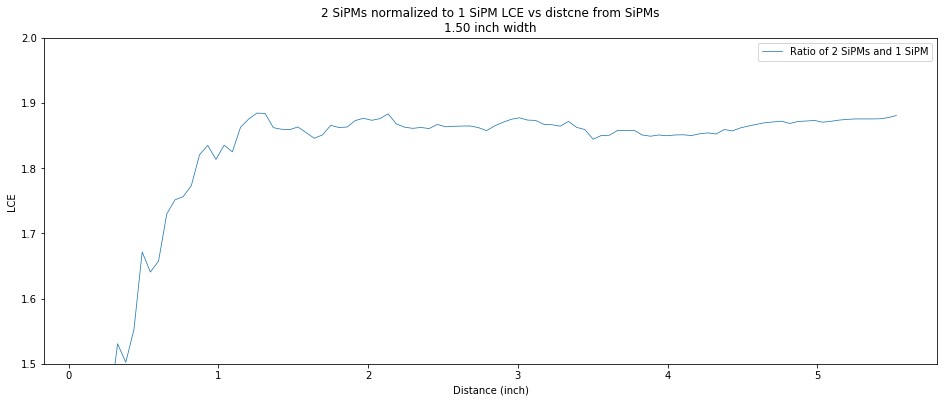

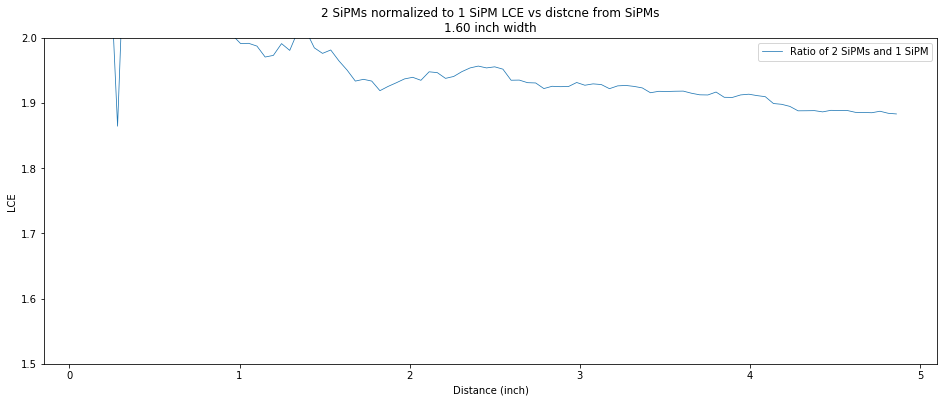

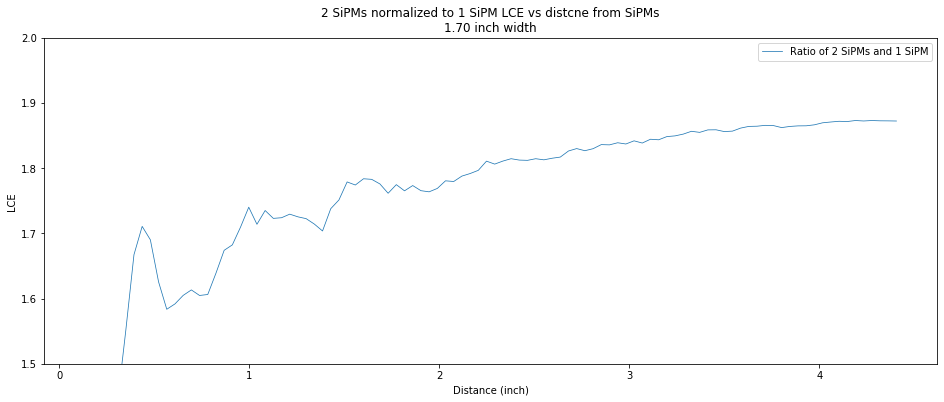

In [12]:

# Graphs for each length comparing the LCE ratio of 2 SiPMs to 1 SiPM
for i in range(widths):
    fig = plt.figure(figsize=(16,6))
    ax = fig.add_subplot(1,1,1)
    plt.title('2 SiPMs normalized to 1 SiPM LCE vs distcne from SiPMs\n{:.2f} inch width'.format(width[i+2]))
    plt.ylabel('LCE')
    plt.xlabel('Distance (inch)')
    ax.set_ylim(bottom = 1.5,top = 2)
    plt.plot(bcs[1,i],averages[1,i]/averages[0,i],label='Ratio of 2 SiPMs and 1 SiPM',lw=0.75)
    
    plt.legend()
    plt.show()